# Mass Fitting

We have to perform mass fitting based on this approach
* 1D mass fitting: One dimension fitting can be perform either on diphoton mass, dibjet mass, or reduced mass. (p.s.  Fitting reduced mass should be a task
* 2D mass fitting: two dimensions fitting, taking two mass at a time. It could be diphoton & dibjet, diphoton & reduced mass, or dibjet & reduced mass.
* 3D mass fitting: most challenging one including all of the masses.

fitting fucntions are:
- [ ] Bernstein polynomials
- [ ] Exponential functions
- [ ] Power law functions
- [ ] Landau distributions
- [ ] Kolmogorov distribution(https://en.wikipedia.org/wiki/Kolmogorov–Smirnov_test#Kolmogorov_distribution)
- [ ] Binned Likelihoods with Templates
- [ ] Johnson Distributions
- [ ] Spline Functions
- [ ]  Double-Sided Crystal Ball Function
- [ ] Generalized Hyperbolic Functions
- [ ] RooFit-specific PDFs
- [ ] Voigt Profile
- [ ] Laurent Series
- [ ] Chebyshev Polynomials


## Crystal ball function

/tmp/sraj/ipykernel_407901/279791780.py:31: RuntimeWarning: invalid value encountered in power
  N * A * (B - z)**-n
/tmp/sraj/ipykernel_407901/279791780.py:20: RuntimeWarning: invalid value encountered in double_scalars
  A = (n / abs(alpha)) ** n * np.exp(-alpha**2 / 2)


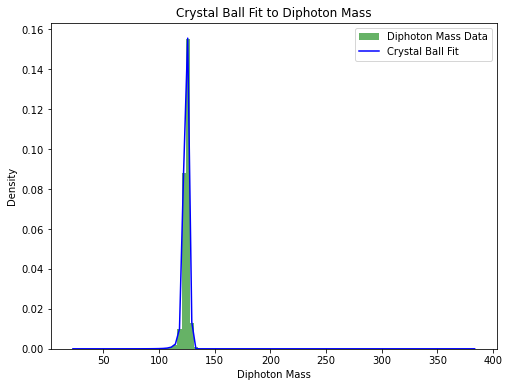

Fitted Crystal Ball Parameters: alpha=1.532, n=4.010, mu=124.653, sigma=2.117


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import erf  # Import the error function
import uproot
import awkward as ak
from vector import Array as awk

# Define the Crystal Ball PDF
def crystalball_pdf(x, alpha, n, mu, sigma):
    """
    Crystal Ball PDF.
    :param x: Input data points
    :param alpha: Tail parameter
    :param n: Tail parameter
    :param mu: Mean of the Gaussian
    :param sigma: Standard deviation of the Gaussian
    :return: PDF values
    """
    A = (n / abs(alpha)) ** n * np.exp(-alpha**2 / 2)
    B = n / abs(alpha) - abs(alpha)
    C = (n / abs(alpha)) * (1 / (n - 1)) * np.exp(-alpha**2 / 2)
    D = np.sqrt(np.pi / 2) * (1 + erf(alpha / np.sqrt(2)))  # Use scipy.special.erf
    
    N = 1 / (sigma * (C + D))
    
    z = (x - mu) / sigma
    pdf = np.where(
        z > -alpha,
        N * np.exp(-0.5 * z**2),
        N * A * (B - z)**-n
    )
    return pdf

# Define the fitting function
def fit_crystalball(data, bins):
    """
    Fit data to the Crystal Ball function.
    :param data: Input data to be fitted
    :param bins: Bin edges for the histogram
    :return: Fitted parameters and bin centers
    """
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # Initial guesses for the parameters: alpha, n, mu, sigma
    initial_params = [1.5, 5, np.mean(data), np.std(data)]
    
    # Fit the histogram data
    params, _ = curve_fit(crystalball_pdf, bin_centers, np.histogram(data, bins=bins, density=True)[0], p0=initial_params)
    return params, bin_centers

# Path to the ROOT file and tree
file_path = "../../../../output_root/v1_v2_comparison/NMSSM_X300_Y60.root"
tree_name = "DiphotonTree/data_125_13TeV_NOTAG/"

# Load the ROOT file and extract variables
with uproot.open(file_path) as file:
    tree = file[tree_name]
    lead_pho_pt = tree["lead_pt"].array(library="ak")
    lead_pho_eta = tree["lead_eta"].array(library="ak")
    lead_pho_phi = tree["lead_phi"].array(library="ak")
    sublead_pho_pt = tree["sublead_pt"].array(library="ak")
    sublead_pho_eta = tree["sublead_eta"].array(library="ak")
    sublead_pho_phi = tree["sublead_phi"].array(library="ak")

# Define the lVector function
def lVector(pt1, eta1, phi1, pt2, eta2, phi2, mass1=0, mass2=0):
    lvec_1 = awk(
        ak.zip({"pt": pt1, "eta": eta1, "phi": phi1, "mass": ak.full_like(pt1, mass1)})
    )
    lvec_2 = awk(
        ak.zip({"pt": pt2, "eta": eta2, "phi": phi2, "mass": ak.full_like(pt2, mass2)})
    )
    lvec_ = lvec_1 + lvec_2
    return lvec_

# Compute the diphoton Lorentz vector
diphoton_ = lVector(
    lead_pho_pt,
    lead_pho_eta,
    lead_pho_phi,
    sublead_pho_pt,
    sublead_pho_eta,
    sublead_pho_phi,
)

# Extract diphoton mass
diphoton_mass = diphoton_.mass

# Convert `diphoton_mass` to NumPy array
diphoton_mass_np = ak.to_numpy(diphoton_mass)

# Define histogram bins
bins = np.linspace(min(diphoton_mass_np), max(diphoton_mass_np), 100)

# Fit the Crystal Ball function to diphoton mass
params, bin_centers = fit_crystalball(diphoton_mass_np, bins)
fitted_curve_cb = crystalball_pdf(bin_centers, *params)

# Plot the histogram and Crystal Ball fit
plt.figure(figsize=(8, 6))
plt.hist(diphoton_mass_np, bins=bins, density=True, alpha=0.6, color="g", label="Diphoton Mass Data")
plt.plot(bin_centers, fitted_curve_cb, "b-", label="Crystal Ball Fit")
plt.xlabel("Diphoton Mass")
plt.ylabel("Density")
plt.title("Crystal Ball Fit to Diphoton Mass")
plt.legend()
plt.show()

# Print fit parameters
print(f"Fitted Crystal Ball Parameters: alpha={params[0]:.3f}, n={params[1]:.3f}, mu={params[2]:.3f}, sigma={params[3]:.3f}")


/tmp/sraj/ipykernel_407901/279791780.py:31: RuntimeWarning: invalid value encountered in power
  N * A * (B - z)**-n
/tmp/sraj/ipykernel_407901/279791780.py:20: RuntimeWarning: invalid value encountered in double_scalars
  A = (n / abs(alpha)) ** n * np.exp(-alpha**2 / 2)


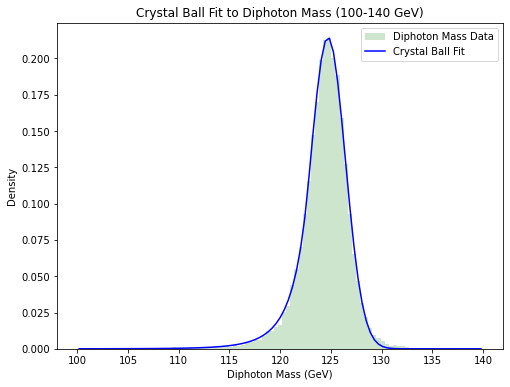

Fitted Crystal Ball Parameters: alpha=1.149, n=7.449, mu=124.715, sigma=1.718


In [20]:
# Define the desired mass range
mass_min = 100
mass_max = 140

# Filter diphoton_mass within the desired range
filtered_mass = diphoton_mass_np[(diphoton_mass_np >= mass_min) & (diphoton_mass_np <= mass_max)]

# Define histogram bins within the reduced range
bins = np.linspace(mass_min, mass_max, 100)

# Fit the Crystal Ball function to the filtered data
params, bin_centers = fit_crystalball(filtered_mass, bins)
fitted_curve_cb = crystalball_pdf(bin_centers, *params)

# Plot the histogram and Crystal Ball fit
plt.figure(figsize=(8, 6))
plt.hist(filtered_mass, bins=bins, density=True, alpha=0.2, color="g", label="Diphoton Mass Data")
plt.plot(bin_centers, fitted_curve_cb, "b-", label="Crystal Ball Fit")
plt.xlabel("Diphoton Mass (GeV)")
plt.ylabel("Density")
plt.title("Crystal Ball Fit to Diphoton Mass (100-140 GeV)")
plt.legend()
plt.show()

# Print fit parameters
print(f"Fitted Crystal Ball Parameters: alpha={params[0]:.3f}, n={params[1]:.3f}, mu={params[2]:.3f}, sigma={params[3]:.3f}")


## KDE

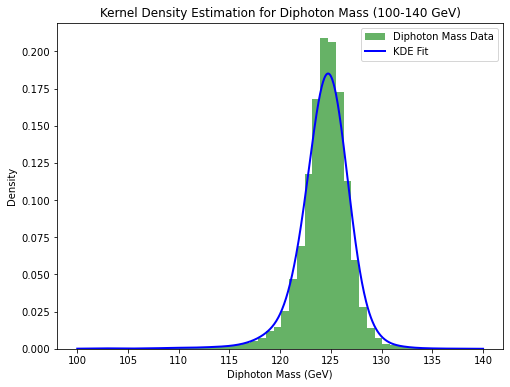

In [21]:
from sklearn.neighbors import KernelDensity
import numpy as np
import matplotlib.pyplot as plt

# Define the desired mass range
mass_min = 100
mass_max = 140

# Filter diphoton_mass within the desired range
filtered_mass = diphoton_mass_np[(diphoton_mass_np >= mass_min) & (diphoton_mass_np <= mass_max)]

# Perform Kernel Density Estimation
kde = KernelDensity(kernel="gaussian", bandwidth=1.0)  # You can tune the bandwidth parameter
filtered_mass_reshaped = filtered_mass[:, np.newaxis]  # Reshape for sklearn
kde.fit(filtered_mass_reshaped)

# Evaluate KDE over the reduced range
x_values = np.linspace(mass_min, mass_max, 1000)  # High resolution for smooth curve
log_density = kde.score_samples(x_values[:, np.newaxis])  # Log density
density = np.exp(log_density)  # Convert log density to actual density

# Plot the histogram and KDE
plt.figure(figsize=(8, 6))
plt.hist(filtered_mass, bins=50, density=True, alpha=0.6, color="g", label="Diphoton Mass Data")
plt.plot(x_values, density, "b-", label="KDE Fit", linewidth=2)
plt.xlabel("Diphoton Mass (GeV)")
plt.ylabel("Density")
plt.title("Kernel Density Estimation for Diphoton Mass (100-140 GeV)")
plt.legend()
plt.show()


## log-normal distribution

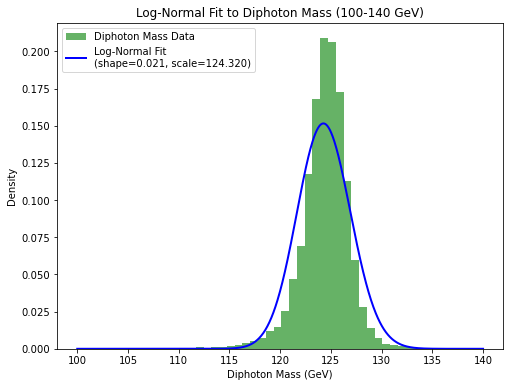

Fitted Log-Normal Parameters: shape=0.021, loc=0.000, scale=124.320


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm

# Define the desired mass range
mass_min = 100
mass_max = 140

# Filter diphoton_mass within the desired range
filtered_mass = diphoton_mass_np[(diphoton_mass_np >= mass_min) & (diphoton_mass_np <= mass_max)]

# Fit a log-normal distribution to the filtered data
shape, loc, scale = lognorm.fit(filtered_mass, floc=0)  # Constrain loc to 0 for a proper log-normal fit

# Evaluate the log-normal PDF
x_values = np.linspace(mass_min, mass_max, 1000)  # High resolution for smooth curve
pdf_values = lognorm.pdf(x_values, shape, loc, scale)

# Plot the histogram and log-normal fit
plt.figure(figsize=(8, 6))
plt.hist(filtered_mass, bins=50, density=True, alpha=0.6, color="g", label="Diphoton Mass Data")
plt.plot(x_values, pdf_values, "b-", label=f"Log-Normal Fit\n(shape={shape:.3f}, scale={scale:.3f})", linewidth=2)
plt.xlabel("Diphoton Mass (GeV)")
plt.ylabel("Density")
plt.title("Log-Normal Fit to Diphoton Mass (100-140 GeV)")
plt.legend()
plt.show()

# Print fit parameters
print(f"Fitted Log-Normal Parameters: shape={shape:.3f}, loc={loc:.3f}, scale={scale:.3f}")


## Gaussian fit

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm  # For Gaussian distribution
import uproot

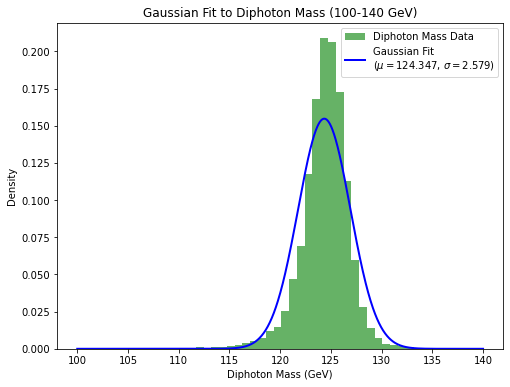

Fitted Gaussian Parameters: mu=124.347, sigma=2.579


In [24]:
# Filter data to the desired range (100-140 GeV)
mass_min = 100
mass_max = 140
filtered_mass = diphoton_mass[(diphoton_mass >= mass_min) & (diphoton_mass <= mass_max)]

# Define histogram bins
bins = 50  # Number of bins in the histogram

# Fit the Gaussian to the data
mu, sigma = norm.fit(filtered_mass)  # Mean and standard deviation

# Generate x-values for the fitted curve
x_values = np.linspace(mass_min, mass_max, 1000)
pdf_values = norm.pdf(x_values, mu, sigma)  # Gaussian PDF

# Plot the histogram and Gaussian fit
plt.figure(figsize=(8, 6))
plt.hist(filtered_mass, bins=bins, density=True, alpha=0.6, color="g", label="Diphoton Mass Data")
plt.plot(x_values, pdf_values, "b-", label=f"Gaussian Fit\n($\\mu={mu:.3f}$, $\\sigma={sigma:.3f}$)", linewidth=2)
plt.xlabel("Diphoton Mass (GeV)")
plt.ylabel("Density")
plt.title("Gaussian Fit to Diphoton Mass (100-140 GeV)")
plt.legend()
plt.show()

# Print fit parameters
print(f"Fitted Gaussian Parameters: mu={mu:.3f}, sigma={sigma:.3f}")


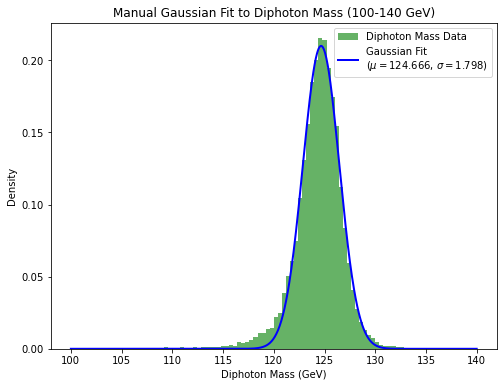

Fitted Gaussian Parameters:
  Mean (mu): 124.666
  Standard Deviation (sigma): 1.798
  Amplitude: 0.210


In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import uproot

# Define the Gaussian function
def gaussian(x, mu, sigma, amplitude):
    """
    Gaussian function.
    :param x: Input data points
    :param mu: Mean of the Gaussian
    :param sigma: Standard deviation of the Gaussian
    :param amplitude: Amplitude of the Gaussian
    :return: Gaussian function values
    """
    return amplitude * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

# Define the cost function for optimization
def cost_function(params, x, y):
    """
    Cost function to minimize for Gaussian fitting.
    :param params: Parameters (mu, sigma, amplitude)
    :param x: Data points (bin centers)
    :param y: Observed histogram values (density)
    :return: Sum of squared residuals
    """
    mu, sigma, amplitude = params
    y_model = gaussian(x, mu, sigma, amplitude)
    return np.sum((y - y_model) ** 2)

# # Load the ROOT file and extract data
# file_path = "../../../output_root/v1_v2_comparison/NMSSM_X300_Y60.root"
# tree_name = "DiphotonTree/data_125_13TeV_NOTAG/"
# with uproot.open(file_path) as file:
#     tree = file[tree_name]
#     diphoton_mass = tree["Res_dijet_mass"].array(library="ak")

# Filter data to the desired range (100-140 GeV)
mass_min = 100
mass_max = 140
filtered_mass = diphoton_mass[(diphoton_mass >= mass_min) & (diphoton_mass <= mass_max)]

# Convert filtered_mass to a NumPy array
filtered_mass_np = np.asarray(filtered_mass)

# Define histogram bins and compute histogram
bins = 100
hist, bin_edges = np.histogram(filtered_mass_np, bins=bins, range=(mass_min, mass_max), density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Initial guesses for the Gaussian parameters: mu, sigma, amplitude
initial_params = [np.mean(filtered_mass_np), np.std(filtered_mass_np), np.max(hist)]

# Use `minimize` to fit the Gaussian function
result = minimize(cost_function, initial_params, args=(bin_centers, hist), method="Nelder-Mead")

# Extract the fitted parameters
fitted_mu, fitted_sigma, fitted_amplitude = result.x

# Generate the fitted curve
x_values = np.linspace(mass_min, mass_max, 1000)
fitted_curve = gaussian(x_values, fitted_mu, fitted_sigma, fitted_amplitude)

# Plot the histogram and fitted Gaussian curve
plt.figure(figsize=(8, 6))
plt.hist(filtered_mass_np, bins=bins, range=(mass_min, mass_max), density=True, alpha=0.6, color="g", label="Diphoton Mass Data")
plt.plot(x_values, fitted_curve, "b-", label=f"Gaussian Fit\n($\\mu={fitted_mu:.3f}$, $\\sigma={fitted_sigma:.3f}$)", linewidth=2)
plt.xlabel("Diphoton Mass (GeV)")
plt.ylabel("Density")
plt.title("Manual Gaussian Fit to Diphoton Mass (100-140 GeV)")
plt.legend()
plt.show()

# Print the fitted parameters
print(f"Fitted Gaussian Parameters:")
print(f"  Mean (mu): {fitted_mu:.3f}")
print(f"  Standard Deviation (sigma): {fitted_sigma:.3f}")
print(f"  Amplitude: {fitted_amplitude:.3f}")


In [26]:
# Template fitting

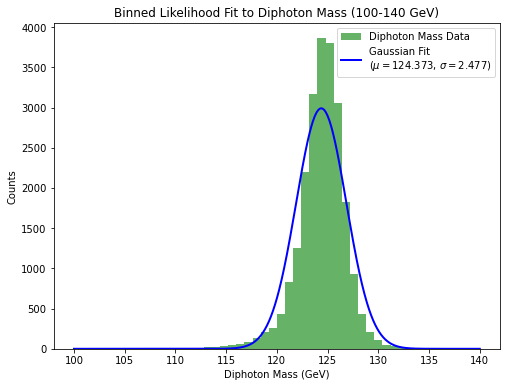

Fitted Gaussian Parameters:
  Mean (mu): 124.373
  Standard Deviation (sigma): 2.477
  Amplitude: 3737.162


In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import uproot

# Define the Gaussian template function
def gaussian_template(x, mu, sigma, amplitude):
    """
    Gaussian function as a template.
    :param x: Input bin centers
    :param mu: Mean of the Gaussian
    :param sigma: Standard deviation of the Gaussian
    :param amplitude: Amplitude of the Gaussian
    :return: Predicted bin counts (template)
    """
    return amplitude * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

# Define the binned negative log-likelihood (NLL)
def binned_nll(params, bin_centers, observed_counts, bin_width):
    """
    Negative log-likelihood for binned data.
    :param params: Model parameters (mu, sigma, amplitude)
    :param bin_centers: Centers of the bins
    :param observed_counts: Observed counts in each bin
    :param bin_width: Width of each bin
    :return: Negative log-likelihood value
    """
    mu, sigma, amplitude = params
    # Predicted counts (template)
    predicted_counts = gaussian_template(bin_centers, mu, sigma, amplitude) * bin_width
    # Avoid division by zero or log of zero
    predicted_counts = np.maximum(predicted_counts, 1e-9)
    observed_counts = np.maximum(observed_counts, 1e-9)
    # Calculate the NLL
    nll = -np.sum(observed_counts * np.log(predicted_counts) - predicted_counts)
    return nll

# # Load the ROOT file and extract data
# file_path = "../../../output_root/v1_v2_comparison/NMSSM_X300_Y60.root"
# tree_name = "DiphotonTree/data_125_13TeV_NOTAG/"
# with uproot.open(file_path) as file:
#     tree = file[tree_name]
#     diphoton_mass = tree["Res_dijet_mass"].array(library="ak")

# Filter data to the desired range (100-140 GeV)
mass_min = 100
mass_max = 140
filtered_mass = diphoton_mass[(diphoton_mass >= mass_min) & (diphoton_mass <= mass_max)]

# Convert filtered_mass to a NumPy array
filtered_mass_np = np.asarray(filtered_mass)

# Define histogram bins and compute histogram
bins = 50
bin_edges = np.linspace(mass_min, mass_max, bins + 1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_width = bin_edges[1] - bin_edges[0]

# Histogram the data to get observed counts
observed_counts, _ = np.histogram(filtered_mass_np, bins=bin_edges)

# Initial guesses for the parameters: mu, sigma, amplitude
initial_params = [np.mean(filtered_mass_np), np.std(filtered_mass_np), np.max(observed_counts)]

# Perform the fit by minimizing the negative log-likelihood
result = minimize(
    binned_nll,
    initial_params,
    args=(bin_centers, observed_counts, bin_width),
    method="Nelder-Mead"
)

# Extract the fitted parameters
fitted_mu, fitted_sigma, fitted_amplitude = result.x

# Generate the fitted template
x_values = np.linspace(mass_min, mass_max, 1000)
fitted_template = gaussian_template(x_values, fitted_mu, fitted_sigma, fitted_amplitude)

# Plot the histogram and fitted Gaussian template
plt.figure(figsize=(8, 6))
plt.hist(
    filtered_mass_np, bins=bin_edges, alpha=0.6, color="g", label="Diphoton Mass Data"
)
plt.plot(
    x_values,
    fitted_template * bin_width,
    "b-",
    label=f"Gaussian Fit\n($\\mu={fitted_mu:.3f}$, $\\sigma={fitted_sigma:.3f}$)",
    linewidth=2,
)
plt.xlabel("Diphoton Mass (GeV)")
plt.ylabel("Counts")
plt.title("Binned Likelihood Fit to Diphoton Mass (100-140 GeV)")
plt.legend()
plt.show()

# Print the fitted parameters
print(f"Fitted Gaussian Parameters:")
print(f"  Mean (mu): {fitted_mu:.3f}")
print(f"  Standard Deviation (sigma): {fitted_sigma:.3f}")
print(f"  Amplitude: {fitted_amplitude:.3f}")


# Kolmogorov–Smirnov test

In [28]:
from scipy.stats import kstest, norm
import numpy as np
import matplotlib.pyplot as plt
import uproot

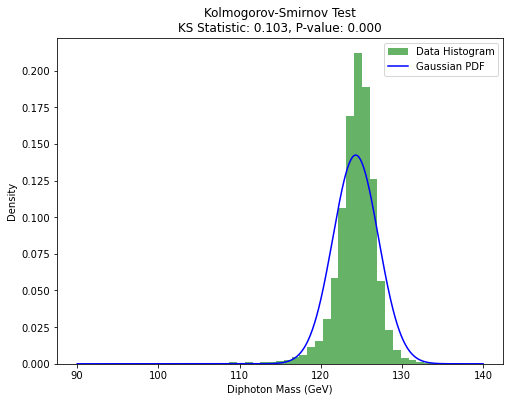

Kolmogorov-Smirnov Test Results:
KS Statistic: 0.103
P-value: 0.000
The null hypothesis (data matches the Gaussian distribution) is rejected.


In [29]:
# Filter data to the desired range (100-140 GeV)
mass_min = 90
mass_max = 140
filtered_mass = diphoton_mass[(diphoton_mass >= mass_min) & (diphoton_mass <= mass_max)]

# Convert filtered_mass to a NumPy array
filtered_mass_np = np.asarray(filtered_mass)

# Fit a Gaussian to the data to obtain parameters (mu, sigma)
fitted_mu = np.mean(filtered_mass_np)
fitted_sigma = np.std(filtered_mass_np)

# Perform the one-sample KS test
# Test if the data follows a Gaussian distribution with fitted parameters
ks_stat, p_value = kstest(
    filtered_mass_np,
    lambda x: norm.cdf(x, loc=fitted_mu, scale=fitted_sigma)
)

# Plot the histogram of the data and the Gaussian CDF
x_values = np.linspace(mass_min, mass_max, 1000)
cdf_values = norm.cdf(x_values, loc=fitted_mu, scale=fitted_sigma)

plt.figure(figsize=(8, 6))
plt.hist(filtered_mass_np, bins=50, density=True, alpha=0.6, color="g", label="Data Histogram")
plt.plot(x_values, norm.pdf(x_values, loc=fitted_mu, scale=fitted_sigma), 'b-', label="Gaussian PDF")
plt.xlabel("Diphoton Mass (GeV)")
plt.ylabel("Density")
plt.title(f"Kolmogorov-Smirnov Test\nKS Statistic: {ks_stat:.3f}, P-value: {p_value:.3f}")
plt.legend()
plt.show()

# Print the results
print("Kolmogorov-Smirnov Test Results:")
print(f"KS Statistic: {ks_stat:.3f}")
print(f"P-value: {p_value:.3f}")

# Interpretation
if p_value < 0.05:
    print("The null hypothesis (data matches the Gaussian distribution) is rejected.")
else:
    print("The null hypothesis cannot be rejected; the data matches the Gaussian distribution.")


# Dibjet($M_{jj}$)


In [30]:
import uproot
import awkward as ak

# Path to the ROOT file and tree
file_path = "../../../../output_root/v1_v2_comparison/NMSSM_X300_Y60.root"
tree_name = "DiphotonTree/data_125_13TeV_NOTAG/"

# Load the ROOT file and extract variables
with uproot.open(file_path) as file:
    tree = file[tree_name]
    
    # Extract b-jet variables
    lead_bjet_pt = tree["Res_lead_bjet_pt"].array(library="ak")    # Transverse momentum of leading b-jet
    lead_bjet_eta = tree["Res_lead_bjet_eta"].array(library="ak")  # Pseudorapidity of leading b-jet
    lead_bjet_phi = tree["Res_lead_bjet_phi"].array(library="ak")  # Azimuthal angle of leading b-jet
    lead_bjet_mass = tree["Res_lead_bjet_mass"].array(library="ak") # Mass of leading b-jet

    sublead_bjet_pt = tree["Res_sublead_bjet_pt"].array(library="ak")    # Transverse momentum of subleading b-jet
    sublead_bjet_eta = tree["Res_sublead_bjet_eta"].array(library="ak")  # Pseudorapidity of subleading b-jet
    sublead_bjet_phi = tree["Res_sublead_bjet_phi"].array(library="ak")  # Azimuthal angle of subleading b-jet
    sublead_bjet_mass = tree["Res_sublead_bjet_mass"].array(library="ak") # Mass of subleading b-jet

    # Extract dijet variables
    dijet_pt = tree["Res_dijet_pt"].array(library="ak")    # Transverse momentum of the dijet system
    dijet_eta = tree["Res_dijet_eta"].array(library="ak")  # Pseudorapidity of the dijet system
    dijet_phi = tree["Res_dijet_phi"].array(library="ak")  # Azimuthal angle of the dijet system
    dijet_mass = tree["Res_dijet_mass"].array(library="ak") # Mass of the dijet system
    
    bbgg_mass = tree["Res_HHbbggCandidate_mass"].array(library="ak")

# Now you have all the required variables extracted directly from the ROOT file
# You can use these variables for further computations or analysis


/tmp/sraj/ipykernel_407901/3068555357.py:31: RuntimeWarning: invalid value encountered in power
  N * A * (B - z)**-n
/tmp/sraj/ipykernel_407901/3068555357.py:20: RuntimeWarning: invalid value encountered in double_scalars
  A = (n / abs(alpha)) ** n * np.exp(-alpha**2 / 2)


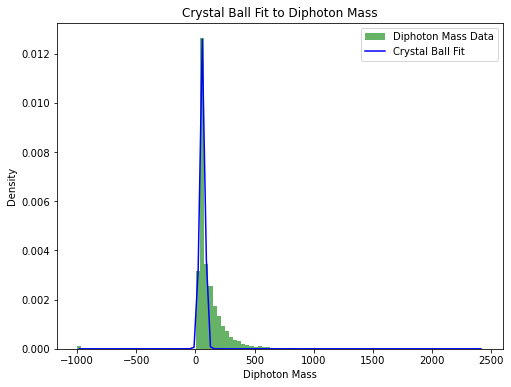

Fitted Crystal Ball Parameters: alpha=3.572, n=1.000, mu=58.796, sigma=21.459


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import erf  # Import the error function
import uproot
import awkward as ak
from vector import Array as awk

# Define the Crystal Ball PDF
def crystalball_pdf(x, alpha, n, mu, sigma):
    """
    Crystal Ball PDF.
    :param x: Input data points
    :param alpha: Tail parameter
    :param n: Tail parameter
    :param mu: Mean of the Gaussian
    :param sigma: Standard deviation of the Gaussian
    :return: PDF values
    """
    A = (n / abs(alpha)) ** n * np.exp(-alpha**2 / 2)
    B = n / abs(alpha) - abs(alpha)
    C = (n / abs(alpha)) * (1 / (n - 1)) * np.exp(-alpha**2 / 2)
    D = np.sqrt(np.pi / 2) * (1 + erf(alpha / np.sqrt(2)))  # Use scipy.special.erf
    
    N = 1 / (sigma * (C + D))
    
    z = (x - mu) / sigma
    pdf = np.where(
        z > -alpha,
        N * np.exp(-0.5 * z**2),
        N * A * (B - z)**-n
    )
    return pdf

# Define the fitting function
def fit_crystalball(data, bins):
    """
    Fit data to the Crystal Ball function.
    :param data: Input data to be fitted
    :param bins: Bin edges for the histogram
    :return: Fitted parameters and bin centers
    """
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # Initial guesses for the parameters: alpha, n, mu, sigma
    initial_params = [1.5, 5, np.mean(data), np.std(data)]
    
    # Fit the histogram data
    params, _ = curve_fit(crystalball_pdf, bin_centers, np.histogram(data, bins=bins, density=True)[0], p0=initial_params)
    return params, bin_centers

# # Path to the ROOT file and tree
# file_path = "../../../../output_root/v1_v2_comparison/NMSSM_X300_Y60.root"
# tree_name = "DiphotonTree/data_125_13TeV_NOTAG/"

# # Load the ROOT file and extract variables
# with uproot.open(file_path) as file:
#     tree = file[tree_name]
#     lead_pho_pt = tree["lead_pt"].array(library="ak")
#     lead_pho_eta = tree["lead_eta"].array(library="ak")
#     lead_pho_phi = tree["lead_phi"].array(library="ak")
#     sublead_pho_pt = tree["sublead_pt"].array(library="ak")
#     sublead_pho_eta = tree["sublead_eta"].array(library="ak")
#     sublead_pho_phi = tree["sublead_phi"].array(library="ak")

# # Define the lVector function
# def lVector(pt1, eta1, phi1, pt2, eta2, phi2, mass1=0, mass2=0):
#     lvec_1 = awk(
#         ak.zip({"pt": pt1, "eta": eta1, "phi": phi1, "mass": ak.full_like(pt1, mass1)})
#     )
#     lvec_2 = awk(
#         ak.zip({"pt": pt2, "eta": eta2, "phi": phi2, "mass": ak.full_like(pt2, mass2)})
#     )
#     lvec_ = lvec_1 + lvec_2
#     return lvec_

# # Compute the diphoton Lorentz vector
# diphoton_ = lVector(
#     lead_pho_pt,
#     lead_pho_eta,
#     lead_pho_phi,
#     sublead_pho_pt,
#     sublead_pho_eta,
#     sublead_pho_phi,
# )

# # Extract diphoton mass
# diphoton_mass = diphoton_.mass

# Convert `diphoton_mass` to NumPy array
diphoton_mass_np = ak.to_numpy(dijet_mass)

# Define histogram bins
bins = np.linspace(min(diphoton_mass_np), max(diphoton_mass_np), 100)

# Fit the Crystal Ball function to diphoton mass
params, bin_centers = fit_crystalball(diphoton_mass_np, bins)
fitted_curve_cb = crystalball_pdf(bin_centers, *params)

# Plot the histogram and Crystal Ball fit
plt.figure(figsize=(8, 6))
plt.hist(diphoton_mass_np, bins=bins, density=True, alpha=0.6, color="g", label="Diphoton Mass Data")
plt.plot(bin_centers, fitted_curve_cb, "b-", label="Crystal Ball Fit")
plt.xlabel("Diphoton Mass")
plt.ylabel("Density")
plt.title("Crystal Ball Fit to Diphoton Mass")
plt.legend()
plt.show()

# Print fit parameters
print(f"Fitted Crystal Ball Parameters: alpha={params[0]:.3f}, n={params[1]:.3f}, mu={params[2]:.3f}, sigma={params[3]:.3f}")


/tmp/sraj/ipykernel_407901/3068555357.py:31: RuntimeWarning: invalid value encountered in power
  N * A * (B - z)**-n
/tmp/sraj/ipykernel_407901/3068555357.py:20: RuntimeWarning: invalid value encountered in double_scalars
  A = (n / abs(alpha)) ** n * np.exp(-alpha**2 / 2)


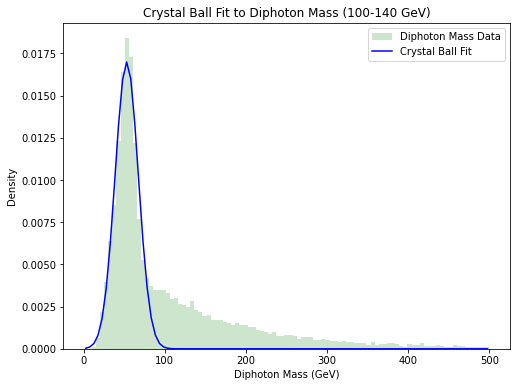

Fitted Crystal Ball Parameters: alpha=3.528, n=1.000, mu=53.107, sigma=14.313


In [7]:
# Define the desired mass range
mass_min = 0
mass_max = 500

# Filter diphoton_mass within the desired range
filtered_mass = diphoton_mass_np[(diphoton_mass_np >= mass_min) & (diphoton_mass_np <= mass_max)]

# Define histogram bins within the reduced range
bins = np.linspace(mass_min, mass_max, 100)

# Fit the Crystal Ball function to the filtered data
params, bin_centers = fit_crystalball(filtered_mass, bins)
fitted_curve_cb = crystalball_pdf(bin_centers, *params)

# Plot the histogram and Crystal Ball fit
plt.figure(figsize=(8, 6))
plt.hist(filtered_mass, bins=bins, density=True, alpha=0.2, color="g", label="Diphoton Mass Data")
plt.plot(bin_centers, fitted_curve_cb, "b-", label="Crystal Ball Fit")
plt.xlabel("Diphoton Mass (GeV)")
plt.ylabel("Density")
plt.title("Crystal Ball Fit to Diphoton Mass (100-140 GeV)")
plt.legend()
plt.show()

# Print fit parameters
print(f"Fitted Crystal Ball Parameters: alpha={params[0]:.3f}, n={params[1]:.3f}, mu={params[2]:.3f}, sigma={params[3]:.3f}")


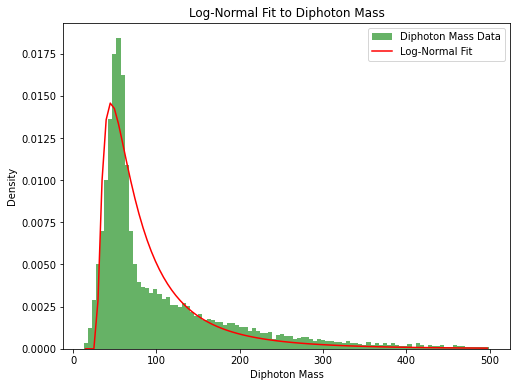

Fitted Log-Normal Parameters: shape=0.933, loc=26.354, scale=45.324


In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm
from scipy.optimize import curve_fit

# Define log-normal PDF
def lognorm_pdf(x, s, loc, scale):
    """
    Log-normal PDF function.
    :param x: Input data points
    :param s: Shape parameter
    :param loc: Location parameter
    :param scale: Scale parameter
    :return: PDF values
    """
    return lognorm.pdf(x, s, loc=loc, scale=scale)

# Fit log-normal distribution to the data
def fit_lognormal(data, bins):
    """
    Fit the histogram of data to a log-normal PDF.
    :param data: Input data array
    :param bins: Histogram bin edges
    :return: Fitted parameters and bin centers
    """
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # Initial guess for the parameters: shape, loc, scale
    initial_params = [1, 0, np.mean(data)]
    
    # Fit the histogram data
    params, _ = curve_fit(
        lognorm_pdf, bin_centers, np.histogram(data, bins=bins, density=True)[0], p0=initial_params
    )
    return params, bin_centers

# Convert `diphoton_mass` to NumPy array
dibjet_mass_np = ak.to_numpy(dijet_mass)
dibjet_mass_np = dibjet_mass_np[(dibjet_mass_np >= 0) & (dibjet_mass_np <= 500)]

# Define histogram bins
bins = np.linspace(min(dibjet_mass_np), max(dibjet_mass_np), 100)

# Fit the log-normal function to the diphoton mass
params, bin_centers = fit_lognormal(dibjet_mass_np, bins)
fitted_curve_ln = lognorm_pdf(bin_centers, *params)

# Plot the histogram and log-normal fit
plt.figure(figsize=(8, 6))
plt.hist(dibjet_mass_np, bins=bins, density=True, alpha=0.6, color="g", label="Diphoton Mass Data")
plt.plot(bin_centers, fitted_curve_ln, "r-", label="Log-Normal Fit")
plt.xlabel("Diphoton Mass")
plt.ylabel("Density")
plt.title("Log-Normal Fit to Diphoton Mass")
plt.legend()
plt.show()

# Print fitted parameters
print(f"Fitted Log-Normal Parameters: shape={params[0]:.3f}, loc={params[1]:.3f}, scale={params[2]:.3f}")


# Reduced mass
Reduced mass defined as 
$\bar{M_X} \equiv m_{\gamma\gamma jj} - (m_{\gamma\gamma} - m_H) - (m_{jj} - m_H or Y)$

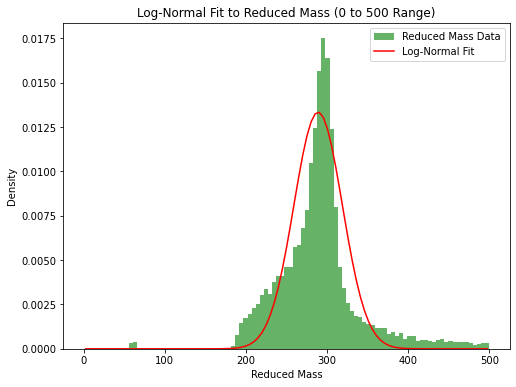

Fitted Log-Normal Parameters: shape=0.000, loc=-168120.421, scale=168409.368


In [32]:
# Extract variables from the ROOT file
with uproot.open(file_path) as file:
    tree = file[tree_name]
    bbgg_mass = tree["Res_HHbbggCandidate_mass"].array(library="ak")  # bbgg_mass
    dibjet_mass = tree["Res_dijet_mass"].array(library="ak")  # dibjet_mass

# Convert extracted variables to NumPy arrays
bbgg_mass_np = ak.to_numpy(bbgg_mass)
dibjet_mass_np = ak.to_numpy(dibjet_mass)

# Compute reduced_mass
reduced_mass = bbgg_mass_np - (diphoton_mass_np - 125) - (dibjet_mass_np - 60)

# Filter reduced_mass within a meaningful range, e.g., [0, 500]
reduced_mass = reduced_mass[(reduced_mass >= 0) & (reduced_mass <= 500)]

# Define histogram bins
bins = np.linspace(0, 500, 100)

# Fit Log-Normal distribution to reduced_mass
params, bin_centers = fit_lognormal(reduced_mass, bins)
fitted_curve_ln = lognorm_pdf(bin_centers, *params)

# Plot the histogram and Log-Normal fit
plt.figure(figsize=(8, 6))
plt.hist(reduced_mass, bins=bins, density=True, alpha=0.6, color="g", label="Reduced Mass Data")
plt.plot(bin_centers, fitted_curve_ln, "r-", label="Log-Normal Fit")
plt.xlabel("Reduced Mass")
plt.ylabel("Density")
plt.title("Log-Normal Fit to Reduced Mass (0 to 500 Range)")
plt.legend()
plt.show()

# Print fitted parameters
print(f"Fitted Log-Normal Parameters: shape={params[0]:.3f}, loc={params[1]:.3f}, scale={params[2]:.3f}")


In [33]:
print("Shape of bbgg_mass_np:", bbgg_mass_np.shape)
print("Shape of diphoton_mass_np:", diphoton_mass_np.shape)
print("Shape of dibjet_mass_np:", dibjet_mass_np.shape)


Shape of bbgg_mass_np: (23304,)
Shape of diphoton_mass_np: (23304,)
Shape of dibjet_mass_np: (23304,)


In [35]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

# Define the double-sided Crystal Ball (DSCB) function
def double_sided_crystalball(x, alpha_low, n_low, alpha_high, n_high, mu, sigma):
    t = (x - mu) / sigma
    result = np.piecewise(
        t,
        [
            t < -alpha_low,
            t > alpha_high,
        ],
        [
            lambda t: np.exp(-0.5 * alpha_low**2)
            * ((n_low / alpha_low) ** n_low)
            * ((n_low / alpha_low - alpha_low - t) ** -n_low),
            lambda t: np.exp(-0.5 * alpha_high**2)
            * ((n_high / alpha_high) ** n_high)
            * ((n_high / alpha_high - alpha_high + t) ** -n_high),
            lambda t: np.exp(-0.5 * t**2),
        ],
    )
    return result

# Fit function for the histogram
def fit_double_sided_crystalball(data, bins):
    # Compute the histogram
    hist, bin_edges = np.histogram(data, bins=bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Initial parameter guesses: alpha_low, n_low, alpha_high, n_high, mu, sigma
    initial_params = [1.5, 2.0, 1.5, 2.0, np.mean(data), np.std(data)]
    
    # Bounds for parameters
    bounds = (
        [0.5, 1.1, 0.5, 1.1, np.min(data), 0.01],  # Lower bounds
        [5.0, 10.0, 5.0, 10.0, np.max(data), 10.0],  # Upper bounds
    )

    # Fit the DSCB to the data
    popt, _ = curve_fit(double_sided_crystalball, bin_centers, hist, p0=initial_params, bounds=bounds, maxfev=10000)

    return popt, bin_centers

# Fit the double-sided Crystal Ball to reduced_mass
params_dscb, bin_centers = fit_double_sided_crystalball(reduced_mass, bins)
fitted_curve_dscb = double_sided_crystalball(bin_centers, *params_dscb)

# Plot the histogram and DSCB fit
plt.figure(figsize=(8, 6))
plt.hist(reduced_mass, bins=bins, density=True, alpha=0.6, color="g", label="Reduced Mass Data")
plt.plot(bin_centers, fitted_curve_dscb, "b-", label="Double-Sided Crystal Ball Fit")
plt.xlabel("Reduced Mass")
plt.ylabel("Density")
plt.title("Double-Sided Crystal Ball Fit to Reduced Mass (0 to 500 Range)")
plt.legend()
plt.show()

# Print fitted parameters
print("Fitted DSCB Parameters:")
print(f"alpha_low = {params_dscb[0]:.3f}, n_low = {params_dscb[1]:.3f}")
print(f"alpha_high = {params_dscb[2]:.3f}, n_high = {params_dscb[3]:.3f}")
print(f"mu = {params_dscb[4]:.3f}, sigma = {params_dscb[5]:.3f}")


ValueError: `x0` is infeasible.